# Language Space Analysis: Left/Right vs Colors

This notebook explores how spatial concepts like "left" and "right" are represented in language embedding space compared to color concepts. We use SigLIP to generate text embeddings and visualize the relationships using PCA and distance plots.

In [1]:
# Import necessary libraries
import sys
from pathlib import Path

# Add parent directory to path to import virgil
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from virgil.image.siglip import SigLIPAligner
from virgil.utils.embeddings import (
    compute_pca,
    compute_distances_to_reference,
    compute_pairwise_distances,
)

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


## Load SigLIP Model

We'll use SigLIP to generate text embeddings for our concepts.

In [2]:
# Initialize SigLIP model
print("Loading SigLIP model...")
aligner = SigLIPAligner(model_name="google/siglip-base-patch16-224")
print(f"Model loaded on device: {aligner.device}")

Loading SigLIP model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Model loaded on device: cuda


## Define Concepts

We'll compare:
- **Spatial concepts**: left, right
- **Color concepts**: red, blue, purple, green, orange, yellow
- **Additional spatial concepts** (for comparison): up, down, forward, backward, inside, outside

In [3]:
# Define our concepts
spatial_concepts = ["left", "right"]
color_concepts = ["red", "blue", "purple", "green", "orange", "yellow"]
additional_concepts = ["up", "down", "inside", "outside"]

# Combine all concepts
all_concepts = spatial_concepts + color_concepts + additional_concepts

print(f"Total concepts: {len(all_concepts)}")
print(f"Spatial (left/right): {spatial_concepts}")
print(f"Colors: {color_concepts}")
print(f"Additional spatial: {additional_concepts}")

Total concepts: 12
Spatial (left/right): ['left', 'right']
Colors: ['red', 'blue', 'purple', 'green', 'orange', 'yellow']
Additional spatial: ['up', 'down', 'inside', 'outside']


## Generate Embeddings

Get embeddings for all concepts using SigLIP.

In [4]:
# Get embeddings for all concepts
print("Generating embeddings...")
embeddings = aligner.get_text_embeddings(all_concepts)
print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")

Generating embeddings...
Embeddings shape: torch.Size([12, 768])
Embedding dimension: 768


## Visualization 1: PCA Scatter Plot

Reduce embeddings to 2D using PCA and visualize the relationships.

Explained variance by PC1: 52.46%
Explained variance by PC2: 11.81%
Total explained variance: 64.27%


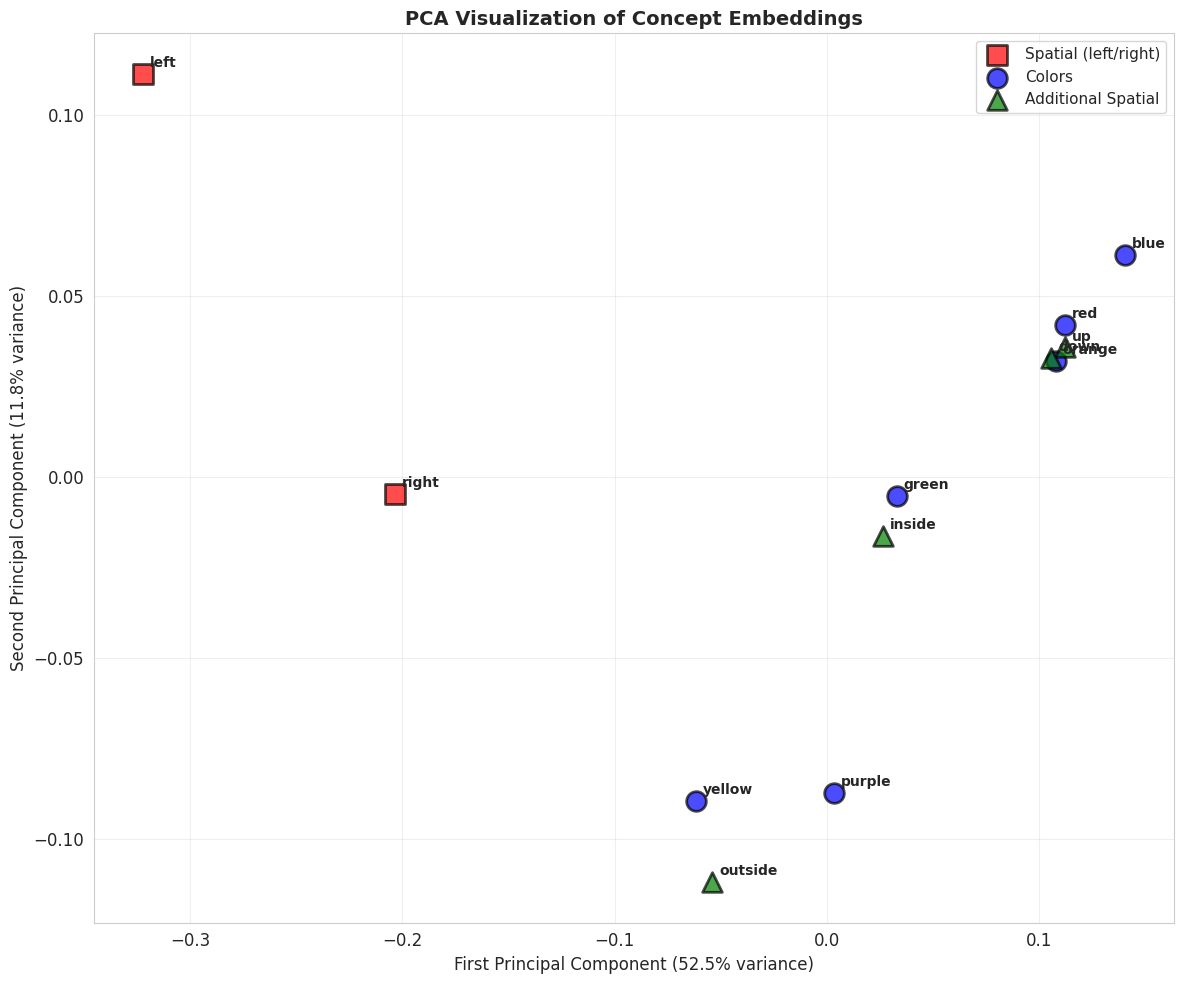

In [5]:
# Compute PCA
reduced_embeddings, pca_model = compute_pca(embeddings, n_components=2)

# Calculate explained variance
explained_variance = pca_model.explained_variance_ratio_
print(f"Explained variance by PC1: {explained_variance[0]:.2%}")
print(f"Explained variance by PC2: {explained_variance[1]:.2%}")
print(f"Total explained variance: {sum(explained_variance):.2%}")

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot different concept groups with different colors and markers
spatial_indices = [all_concepts.index(c) for c in spatial_concepts]
color_indices = [all_concepts.index(c) for c in color_concepts]
additional_indices = [all_concepts.index(c) for c in additional_concepts]

# Plot spatial concepts (left/right)
ax.scatter(
    reduced_embeddings[spatial_indices, 0],
    reduced_embeddings[spatial_indices, 1],
    c="red",
    marker="s",
    s=200,
    label="Spatial (left/right)",
    alpha=0.7,
    edgecolors="black",
    linewidths=2,
)

# Plot color concepts
ax.scatter(
    reduced_embeddings[color_indices, 0],
    reduced_embeddings[color_indices, 1],
    c="blue",
    marker="o",
    s=200,
    label="Colors",
    alpha=0.7,
    edgecolors="black",
    linewidths=2,
)

# Plot additional spatial concepts
ax.scatter(
    reduced_embeddings[additional_indices, 0],
    reduced_embeddings[additional_indices, 1],
    c="green",
    marker="^",
    s=200,
    label="Additional Spatial",
    alpha=0.7,
    edgecolors="black",
    linewidths=2,
)

# Add labels for each point
for i, concept in enumerate(all_concepts):
    ax.annotate(
        concept,
        (reduced_embeddings[i, 0], reduced_embeddings[i, 1]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel(
    f"First Principal Component ({explained_variance[0]:.1%} variance)", fontsize=12
)
ax.set_ylabel(
    f"Second Principal Component ({explained_variance[1]:.1%} variance)", fontsize=12
)
ax.set_title("PCA Visualization of Concept Embeddings", fontsize=14, fontweight="bold")
ax.legend(loc="best", fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualization 2: Distance Bar Plot

Compute distances from each concept to "left" and "right" to see which concepts are closer to spatial concepts vs color concepts.

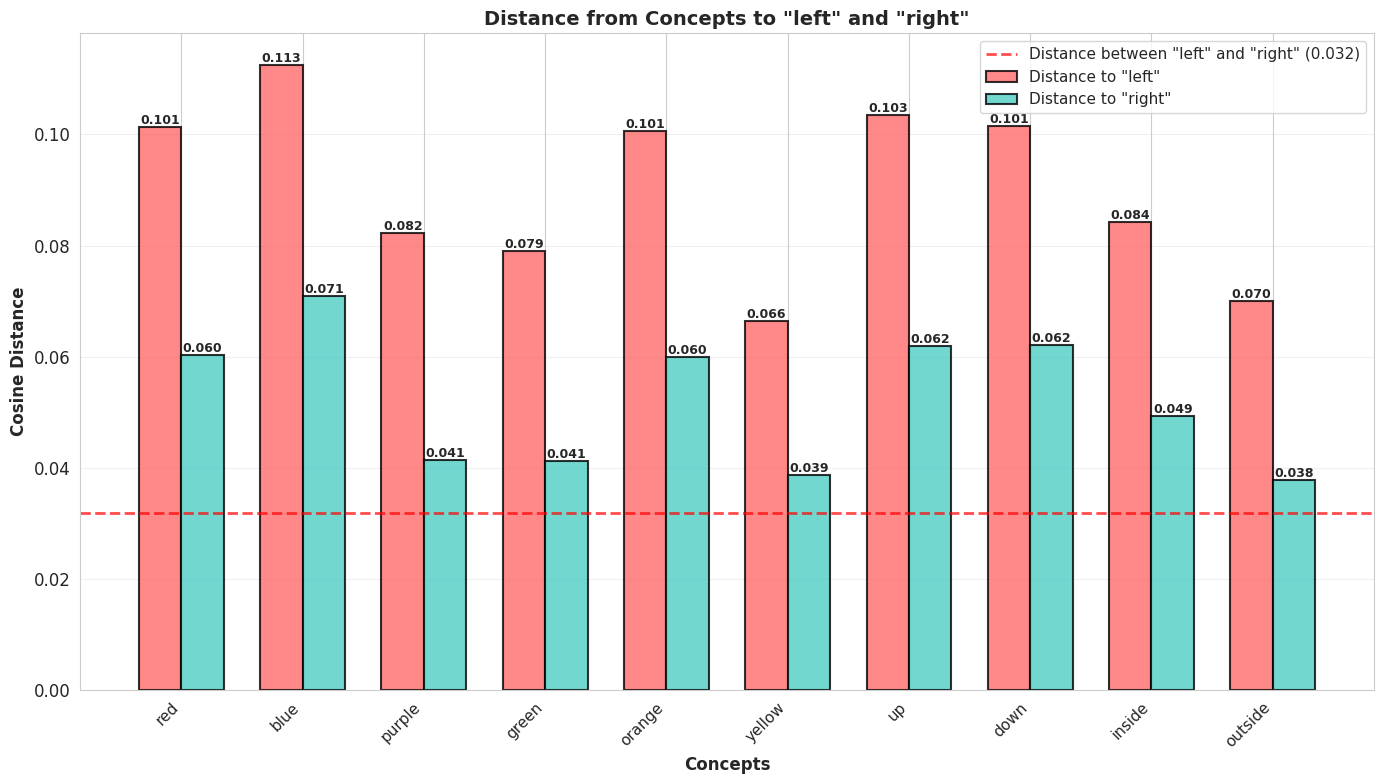


=== Summary Statistics ===
Distance between 'left' and 'right': 0.0319

Average distance from colors to 'left': 0.0904
Average distance from colors to 'right': 0.0521

Average distance from additional spatial to 'left': 0.0898
Average distance from additional spatial to 'right': 0.0528


In [6]:
# Compute distances to "left" and "right"
distances = compute_distances_to_reference(embeddings, all_concepts, spatial_concepts)

# Calculate average distances for in-group (additional spatial) and out-group (colors)
in_group = additional_concepts  # spatial concepts: up, down, inside, outside
out_group = color_concepts  # color concepts: red, blue, purple, green, orange, yellow

# Compute averages
in_group_avg_left = np.mean([distances[c]["left"] for c in in_group])
in_group_avg_right = np.mean([distances[c]["right"] for c in in_group])
out_group_avg_left = np.mean([distances[c]["left"] for c in out_group])
out_group_avg_right = np.mean([distances[c]["right"] for c in out_group])

# Prepare data for plotting
categories = ["In-Group\n(Spatial)", "Out-Group\n(Colors)"]
left_avgs = [in_group_avg_left, out_group_avg_left]
right_avgs = [in_group_avg_right, out_group_avg_right]

# Create bar plot
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 8))

bars1 = ax.bar(
    x - width / 2,
    left_avgs,
    width,
    label='Average Distance to "left"',
    color="#FF6B6B",
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)
bars2 = ax.bar(
    x + width / 2,
    right_avgs,
    width,
    label='Average Distance to "right"',
    color="#4ECDC4",
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=11,
            fontweight="bold",
        )

ax.set_xlabel("Concept Group", fontsize=12, fontweight="bold")
ax.set_ylabel("Average Cosine Distance", fontsize=12, fontweight="bold")
ax.set_title(
    'Average Distance: In-Group vs Out-Group to "left" and "right"',
    fontsize=14,
    fontweight="bold",
)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=11, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis="y")

# Add a horizontal line showing the distance between left and right
left_right_distance = distances["left"]["right"]
ax.axhline(
    y=left_right_distance,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f'Distance between "left" and "right" ({left_right_distance:.3f})',
    alpha=0.7,
)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Summary Statistics ===")
print(f"Distance between 'left' and 'right': {left_right_distance:.4f}")
print(f"\nIn-Group (Spatial: {', '.join(in_group)}):")
print(f"  Average distance to 'left': {in_group_avg_left:.4f}")
print(f"  Average distance to 'right': {in_group_avg_right:.4f}")
print(f"\nOut-Group (Colors: {', '.join(out_group)}):")
print(f"  Average distance to 'left': {out_group_avg_left:.4f}")
print(f"  Average distance to 'right': {out_group_avg_right:.4f}")

## Additional Analysis: Pairwise Distance Matrix

Let's also visualize the full pairwise distance matrix to see all relationships.

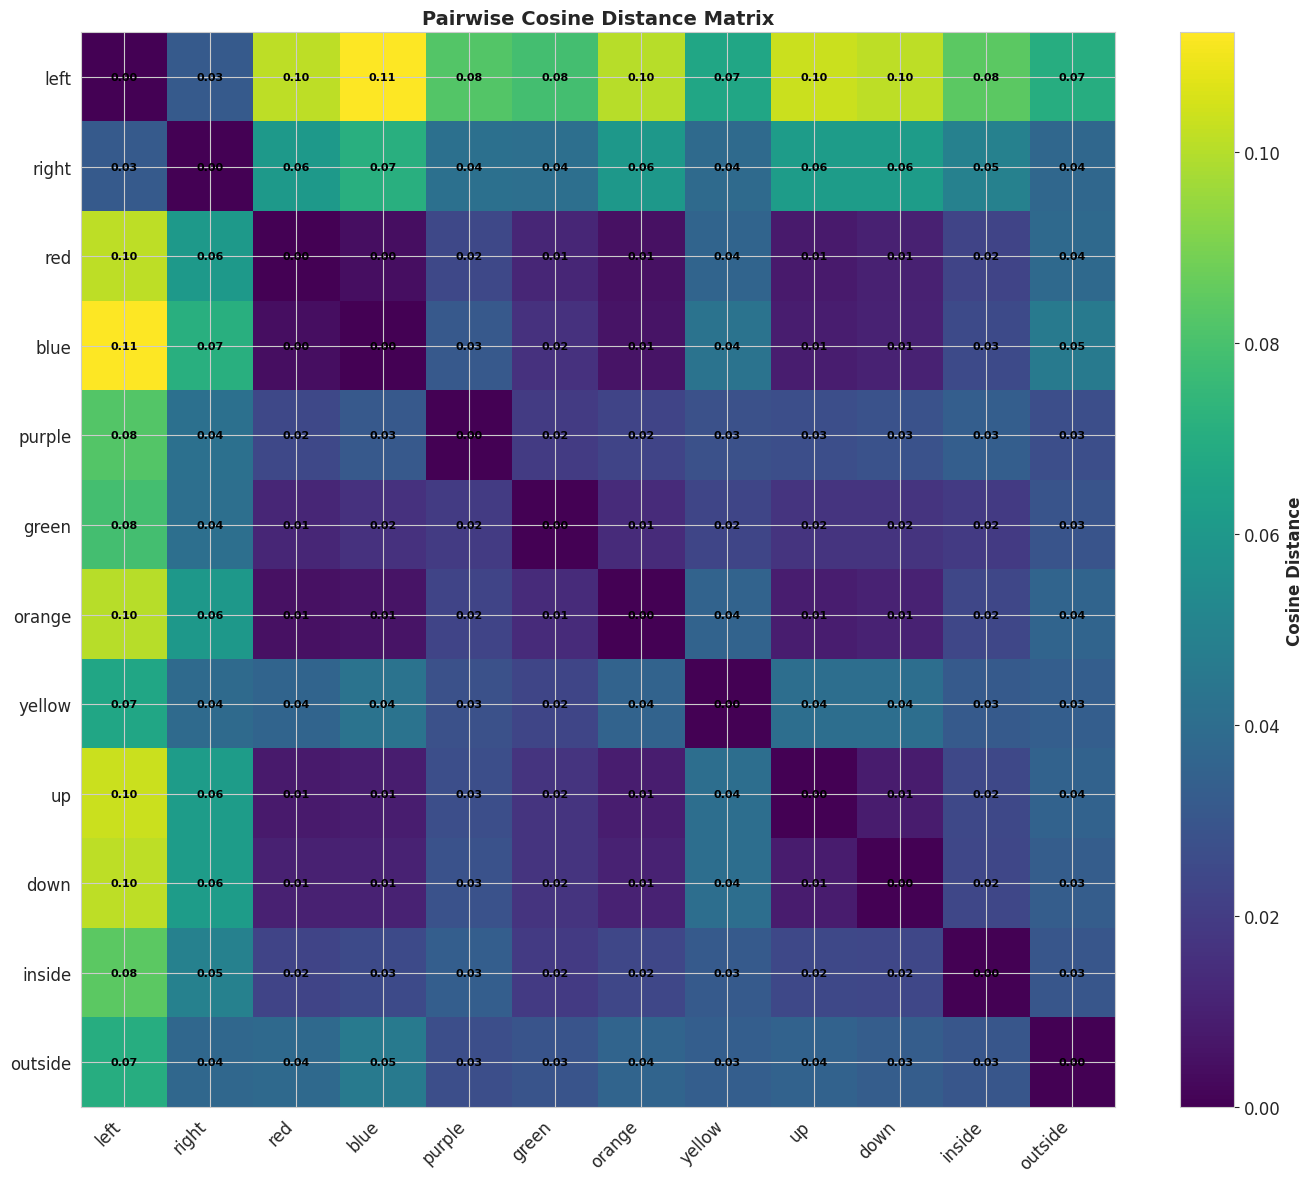

In [7]:
# Compute pairwise distances
distance_matrix, _ = compute_pairwise_distances(embeddings, all_concepts)

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

im = ax.imshow(distance_matrix, cmap="viridis", aspect="auto")

# Set ticks and labels
ax.set_xticks(np.arange(len(all_concepts)))
ax.set_yticks(np.arange(len(all_concepts)))
ax.set_xticklabels(all_concepts, rotation=45, ha="right")
ax.set_yticklabels(all_concepts)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Cosine Distance", fontsize=12, fontweight="bold")

# Add text annotations
for i in range(len(all_concepts)):
    for j in range(len(all_concepts)):
        text = ax.text(
            j,
            i,
            f"{distance_matrix[i, j]:.2f}",
            ha="center",
            va="center",
            color="white" if distance_matrix[i, j] > 0.5 else "black",
            fontsize=8,
            fontweight="bold",
        )

ax.set_title("Pairwise Cosine Distance Matrix", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## Observations

From the visualizations above, we can observe:

1. **PCA Plot**: Shows how concepts cluster in the embedding space. Spatial concepts (left/right) may cluster differently from color concepts.

2. **Distance Bar Plot**: Shows that:
   - Color concepts tend to have similar distances to both "left" and "right"
   - Additional spatial concepts (up, down, forward, etc.) may be closer to "left" and "right" than colors are
   - The distance between "left" and "right" itself provides a baseline

3. **Distance Matrix**: Provides a complete view of all pairwise relationships between concepts.

This analysis helps us understand how different types of concepts are organized in the language embedding space.